# Notebook 1: Reproduce RGCN Model with APIs

This notebook is the first in a series that demonstrates how to use GraphStorm's APIs to create users' own graph machine learning setup by leveraging GraphStorm's easy-to-use and great scalability features. All of these notebooks are designed to run on GraphStorm's Standalone mode, i.e., in a single Linux machine with CPUs and GPUs. 

In this notebook, we willl reproduce the GraphStorm RGCN model with the nessessary APIs and use it to conduct a node classification task on the ACM dataset. By playing with this notebook, users will be able to get familiar with these APIs.

### Prerequsites

- GraphStorm installed using pip. Please find [more details on installation of GraphStorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).
- ACM data created in the [Notebook 0: Data Prepare](https://graphstorm.readthedocs.io/en/latest/notebooks/Notebook_0_Data_Prepare.html), and is stored in the `./acm_gs_1p/` folder.
- Installation of supporting libraries, e.g., matplotlib.

### Import libraries

In [1]:
# Import supporting libraries
import os
import matplotlib.pyplot as plt

# Setup log level
import logging
logging.basicConfig(level=20)

# Import GraphStorm APIs
import graphstorm as gs
from graphstorm.trainer import GSgnnNodePredictionTrainer
from graphstorm.dataloading import GSgnnNodeTrainData, GSgnnNodeDataLoader, GSgnnNodeInferData
from graphstorm.model import (GSgnnNodeModel,
                              GSNodeEncoderInputLayer,
                              RelationalGCNEncoder,
                              EntityClassifier,
                              ClassifyLossFunc)
from graphstorm.inference import GSgnnNodePredictionInferrer
from graphstorm.eval import GSgnnAccEvaluator
from graphstorm.tracker import GSSageMakerTaskTracker

---

### 0. Initialize the GraphStorm Standalone Environment

In [2]:
gs.initialize(ip_config=None, backend='gloo')
device = gs.utils.setup_device(0)

### 1. Setup Graph Data Information

First, let's setup the information of the ACM graph data for GraphStorm model training and inference.

In [3]:
acm_graph_config = './acm_gs_1p/acm.json'
graph_name = 'acm'

### 2. Setup GraphStorm Dataset and DataLoaders

In [4]:
# create a GraphStorm Dataset for the ACM graph data 
train_data = GSgnnNodeTrainData(graph_name=graph_name,
                              part_config=acm_graph_config,
                              train_ntypes='paper',            # node type/s for training
                              eval_ntypes='paper',             # node type/s for evaluation and testing
                              node_feat_field={'author':['feat'], 'paper':['feat'],'subject':['feat']},     # ?What if multiple features, e.g., feat1, feat2?
                              label_field='label')             # name of the label field, 

INFO:root:part 0, train: 9999, val: 1249, test: 1249


In [5]:
# setup data loaders for training, validation, and test
train_dataloader = GSgnnNodeDataLoader(dataset=train_data,
                                       target_idx=train_data.train_idxs,
                                       fanout=[5,5],
                                       batch_size=64,
                                       device=device,
                                       train_task=True)
val_dataloader = GSgnnNodeDataLoader(dataset=train_data,
                                     target_idx=train_data.val_idxs,
                                     fanout=[5,5],
                                     batch_size=256,
                                     device=device,
                                     train_task=False)
test_dataloader = GSgnnNodeDataLoader(dataset=train_data,
                                      target_idx=train_data.test_idxs,
                                      fanout=[5,5],
                                      batch_size=256,
                                      device=device,
                                      train_task=False)

### 3. Reproduce the GraphStorm RGCN Model for Node Classification 

Next, we use a set of GraphStorm APIs to reproduce the built-in RGCN model.

A GraphStorm model should contain the following components: 
- Input encoder for nodes (and optionally edges): process and project input features and embeddings into a certain dimension;
- GNN encoder: performs message-passing on projected node/edge inputs;
- Decoder: specific for tasks on the graph.

We can see the following codes set up a `GSgnnNodeModel` model composed of `GSNodeEncoderInputLayer`, `RelationalGCNEncoder`, `EntityClassifier` step-by-step. One can also replace individual components/layers with a custom model for development purpose.

In [6]:
# create a GraphStorm model for node tasks
model = GSgnnNodeModel(alpha_l2norm=0.)

# set an input layer encoder
encoder = GSNodeEncoderInputLayer(g=train_data.g,
                                  feat_size={'author':256, 'paper':256, 'subject':256}, # ?What if multiple features, e.g., feat1, feat2?
                                  embed_size=64)
model.set_node_input_encoder(encoder)

# set a GNN encoder
gnn_encoder = RelationalGCNEncoder(g=train_data.g,
                                   h_dim=64,
                                   out_dim=128,
                                   num_hidden_layers=1)    # MUST be len(fanout)-1 !!
model.set_gnn_encoder(gnn_encoder)

# set a decoder specific to node-classification task
decoder = EntityClassifier(in_dim=128,
                           num_classes=14,
                           multilabel=False)
model.set_decoder(decoder)

# classification loss function
model.set_loss_func(ClassifyLossFunc(multilabel=False))

# initialize model's optimizer
model.init_optimizer(lr=0.001,
                     sparse_optimizer_lr=0.01,
                     weight_decay=0)

# (Optional) uncomment to display the model architecture
# model

### 4. Setup GraphStorm Training Pipeline

GraphStorm uses its Trainers to train the RGCN model. It handles:
1. model training/evaluation loops
2. saving and recording best performed models 
3. early-stopping

In [14]:
# create a GraphStorm node task trainer for the RGCN model
trainer = GSgnnNodePredictionTrainer(model)

# setup device for the trainer
trainer.setup_device(device=device)

# setup evaluator for the trainer:
evaluator = GSgnnAccEvaluator(eval_frequency=20,
                              eval_metric=['roc_auc', 'precision_recall'],
                              multilabel=False)

# setup a task tracker to output running information
task_tracker = GSSageMakerTaskTracker(log_report_frequency=40)
evaluator.setup_task_tracker(task_tracker)

trainer.setup_evaluator(evaluator)

In [15]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=2,
            save_model_path='nc_model/')

INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 1.2975 | Time: 0.0262
ERROR:root:Failure found during evaluation of the auc metric returning -1: Number of classes in y_true not equal to the number of columns in 'y_score'
ERROR:root:Failure found during evaluation of the auc metric returning -1: multiclass format is not supported
ERROR:root:Failure found during evaluation of the auc metric returning -1: Number of classes in y_true not equal to the number of columns in 'y_score'
ERROR:root:Failure found during evaluation of the auc metric returning -1: multiclass format is not supported
INFO:root:Part 0 | Epoch 00000 | Batch 020 | Loss: 1.0840 | Time: 0.0336
ERROR:root:Failure found during evaluation of the auc metric returning -1: Number of classes in y_true not equal to the number of columns in 'y_score'
ERROR:root:Failure found during evaluation of the auc metric returning -1: multiclass format is not supported
ERROR:root:Failure found during evaluation of the auc metric returning 

### 5. Visualize Model Performance History

Next, we examine the model performance on the validation and testing sets over the training process.

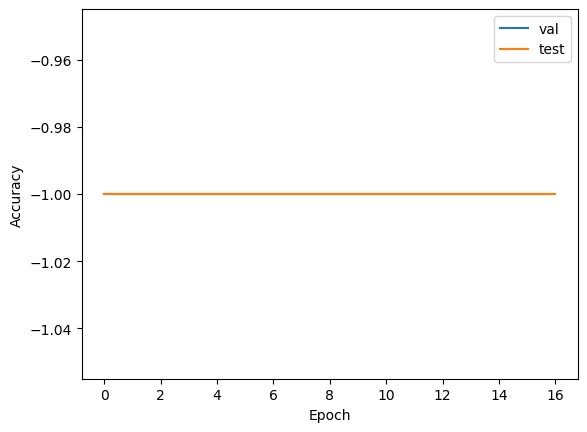

In [17]:
# extract evaluation history of metrics from the trainer's evaluator:
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['roc_auc'])
    test_metrics.append(test_metric['roc_auc'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val')
ax.plot(test_metrics, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best')

### 6. Inference with the Trained Model

GraphStorm automatically save the best performaned model in the given `save_model_path` argument. We can first find out what is the best model and its path.

In [12]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

Best model path: nc_model/epoch-0


In [13]:
# check the saved model artifacts
!ls -ls {best_model_path}

total 1616
 540 -rw-rw-r-- 1 ubuntu ubuntu  551053 Jan 26 06:18 model.bin
1076 -rw-rw-r-- 1 ubuntu ubuntu 1101026 Jan 26 06:18 optimizers.bin


In [14]:
# we can restore the model from the saved path:
model.restore_model(best_model_path)

INFO:root:successfully load the model from nc_model/epoch-0
INFO:root:Time on load model: 0.006 seconds


In [16]:
# Create a dataset for inference, we use the same ACM graph
infer_data = GSgnnNodeInferData(graph_name=graph_name,
                                part_config=acm_graph_config,
                                eval_ntypes='paper',
                                node_feat_field={'author':['feat'], 'paper':['feat'],'subject':['feat']},
                                label_field='label')

# Setup dataloader for the inference dataset
infer_dataloader = GSgnnNodeDataLoader(dataset=infer_data,
                                       target_idx=infer_data.test_idxs,
                                       fanout=[50,50],
                                       batch_size=100,
                                       device=device,
                                       train_task=False)

# Create an Inferrer object
infer = GSgnnNodePredictionInferrer(model)

In [17]:
# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

INFO:root:save embeddings pf paper to infer/embeddings
INFO:root:Writing GNN embeddings to infer/embeddings in pytorch format.


In [18]:
# The GNN embeddings and predictions on the inference graph are saved to the folder named after the target_ntype
!ls -lh infer/embeddings/paper

total 328K
-rw-rw-r-- 1 ubuntu ubuntu 314K Jan 26 06:19 embed-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu  11K Jan 26 06:19 embed_nids-00000.pt


In [19]:
!ls -lh infer/predictions/paper

total 84K
-rw-rw-r-- 1 ubuntu ubuntu 70K Jan 26 06:19 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 11K Jan 26 06:19 predict_nids-00000.pt
